In [2]:
import pandas as pd
import os
import loc_utils


### Import clean data

df_langdetect.csv contains the information on the languages used in the df. However since the clean up might be better than when we originally did the classification We will first realign the two.



### Call DeepL for translations

In [4]:
if os.path.exists(loc_utils.deepl_file):
    df_translate = pd.read_csv(loc_utils.deepl_file, index_col='productid')
    print('found deepL output file and will continue from there')
else:
    if os.path.exists('language_analysis/df_lang.csv'):
        print("found 'language_analysis/df_lang.csv', will not run text_cleaner")
        df_lang = pd.read_csv('language_analysis/df_lang.csv', index_col=0)
    else:
        print("did not found 'language_analysis/df_lang.csv', will run text_cleaner")
        df_lang = loc_utils.import_clean_data()
    df_translate = loc_utils.safe_create_column('deepL_translation', df_translate)
    df_translate = df_translate.set_index('productid')
    df_translate.to_csv(loc_utils.deepl_file)
    print('creating deepL output file')

found deepL output file and will continue from there


DeepL has a free offering for their API which is restricted to 500,000 per month per account. Since we might not be able to simply translate everything, 
we want to start off understanding the elements that are not in French to evaluate which ones we want to translate first.

In [5]:
# getting some number to evaluate localization strategies
characters = int(df_translate.loc[(~df_translate['lang'].isin(loc_utils.ignore_language_codes)) & (df_translate['deepL_translation'].isna())]['merged_text'].str.len().sum())

DeepL_free_limit = 500000

print(f'We have {characters:,} characters that we still need to localize. Assuming that we use a free account of DeepL we would need {characters//DeepL_free_limit+1} accounts or months to localize everything into French')

We have 1,134,678 characters that we still need to localize. Assuming that we use a free account of DeepL we would need 3 accounts or months to localize everything into French


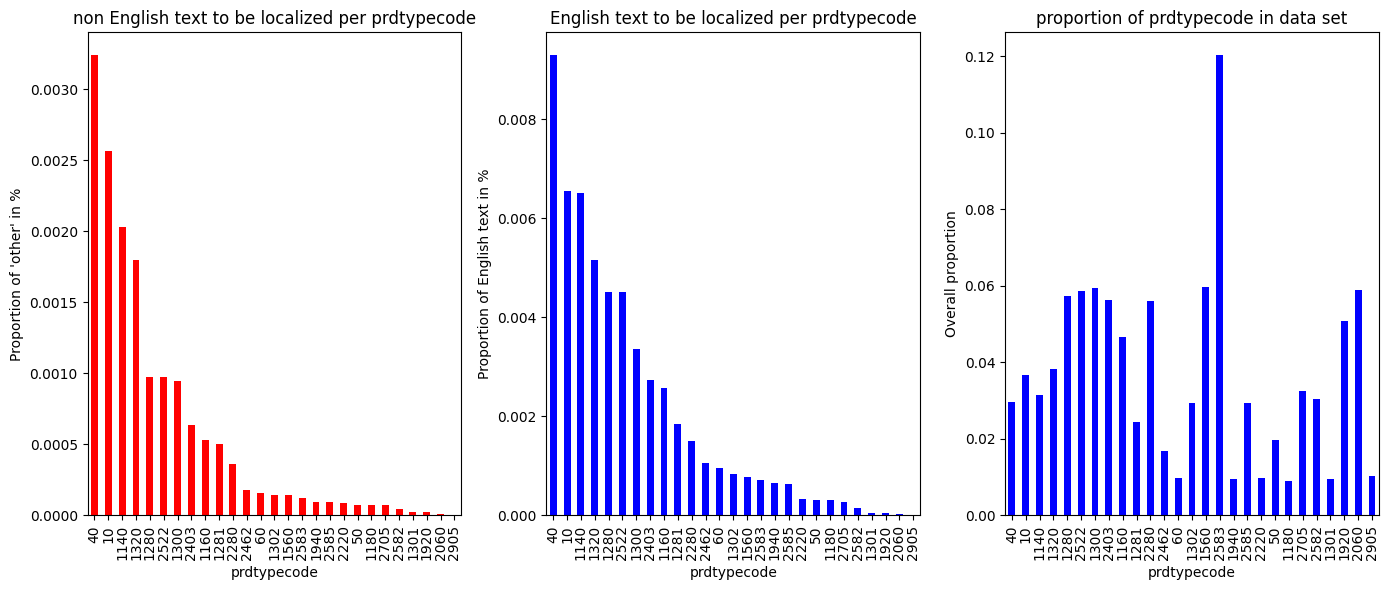

In [4]:
import matplotlib.pyplot as plt 
freq_counts = pd.crosstab(df_translate['prdtypecode'], df_translate.loc[df_translate['deepL_translation'].isna()]['lang'].apply(lambda x: x if x in ['fr', 'en'] else 'other'), normalize=True)

# Compute "other" proportion per prdtypecode
other_freq = freq_counts['other'].sort_values(ascending=False)

en_freq = freq_counts['en'].sort_values(ascending=False)

# Compute overall proportion of each prdtypecode
overall_freq = df_translate['prdtypecode'].value_counts(normalize=True)

# Reindex `overall_freq` to match the order of `other_freq`
overall_freq = overall_freq.reindex(other_freq.index, fill_value=0)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharex=True)

# Plot proportion of "other" per prdtypecode
other_freq.plot(kind="bar", color="red", ax=axes[0])
axes[0].set_title("non English text to be localized per prdtypecode")
axes[0].set_xlabel("prdtypecode")
axes[0].set_ylabel("Proportion of 'other' in %")

# Plot overall proportion of each prdtypecode (same order)
en_freq.plot(kind="bar", color="blue", ax=axes[1])
axes[1].set_title("English text to be localized per prdtypecode")
axes[1].set_xlabel("prdtypecode")
axes[1].set_ylabel("Proportion of English text in %")

# Plot overall proportion of each prdtypecode (same order)
overall_freq.plot(kind="bar", color="blue", ax=axes[2])
axes[2].set_title("proportion of prdtypecode in data set")
axes[2].set_xlabel("prdtypecode")
axes[2].set_ylabel("Overall proportion")

# Adjust layout
plt.tight_layout()
plt.show();

### Calling the DeepL API

The DeepL documentation used for this can be found https://developers.deepl.com/docs/getting-started/your-first-api-request

In [9]:
try:
    df_translate = loc_utils.apply_translation_conditionally_in_chunks(df_translate, chunk_size=200)
    df_translate.to_csv(loc_utils.deepl_file, index=False)
    print('{loc_utils.deepl_file} was updated')
except Exception as e:
    df_deepL_output = pd.read_csv(loc_utils.deepl_output_file, index_col='productid').drop_duplicates()
    df_translate.combine_first(df_deepL_output).to_csv(loc_utils.deepl_file)
    print(f'Error: {e} \n\
          updating {loc_utils.deepl_file} from {loc_utils.deepl_output_file}')
    


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

84717 rows left to run
84517 rows left to run
84317 rows left to run
84117 rows left to run
83917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


83717 rows left to run
83517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


83317 rows left to run
83117 rows left to run
82917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

82717 rows left to run
82517 rows left to run
82317 rows left to run
82117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

81917 rows left to run
81717 rows left to run
81517 rows left to run
81317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

81117 rows left to run
80917 rows left to run
80717 rows left to run
80517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

80317 rows left to run
80117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


79917 rows left to run
79717 rows left to run
79517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

79317 rows left to run
79117 rows left to run
78917 rows left to run
78717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

78517 rows left to run
78317 rows left to run
78117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

77917 rows left to run
77717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


77517 rows left to run
77317 rows left to run
77117 rows left to run
76917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

76717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


76517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


76317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


76117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


75917 rows left to run
75717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


75517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


75317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


75117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


74917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


74717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


74517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


74317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


74117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


73917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


73717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


73517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


73317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


73117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


72917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


72717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


72517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


72317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


72117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


71917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


71717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


71517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


71317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


71117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


70917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


70717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


70517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


70317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


70117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


69917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


69717 rows left to run
69517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


69317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


69117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


68917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


68717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


68517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


68317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


68117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


67917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


67717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


67517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


67317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


67117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


66917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


66717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


66517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


66317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


66117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


65917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


65717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


65517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


65317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


65117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


64917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


64717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


64517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


64317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


64117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


63917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


63717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


63517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


63317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


63117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


62917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


62717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


62517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


62317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


62117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


61917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


61717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


61517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


61317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


61117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


60917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


60717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


60517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


60317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


60117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


59917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


59717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


59517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


59317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


59117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


58917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A

58717 rows left to run
58517 rows left to run
58317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


58117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


57917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


57717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


57517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


57317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


57117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


56917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


56717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


56517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


56317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


56117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


55917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


55717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


55517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


55317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


55117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


54917 rows left to run
54717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


54517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


54317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


54117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


53917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


53717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


53517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


53317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


53117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


52917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


52717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


52517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


52317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


52117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


51917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


51717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


51517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


51317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


51117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


50917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


50717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


50517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


50317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


50117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


49917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


49717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


49517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


49317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


49117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


48917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


48717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


48517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


48317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


48117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


47917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


47717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


47517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


47317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


47117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


46917 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


46717 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


46517 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


46317 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


46117 rows left to run


/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)
/Users/robertwilson/Documents/GitHub/feb25_bds_classification-of-rakuten-e-commerce-products/loc_utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[mask, 'deepL_translation'] = df.loc[mask, 'merged_text'].apply(deepl_translation)


45917 rows left to run
45717 rows left to run
Error: Quota for this billing period has been exceeded, message: Quota Exceeded 
          updating language_analysis/df_localization.csv from language_analysis/deepL_result.csv
